### Gearbox single node throughput analysis 
#### Peixuan 02052020


In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from collections import OrderedDict
import matplotlib.pyplot as plt

In [2]:
#Directory = "gpx_data/PLdata"
#Directory = "wmq_data"
#Directory = "18xxx"
Directory = "4"
#Directory = "19xxxb"

In [3]:
def process_data(df, timerange):
    df.drop_duplicates(subset = 'Timestamp',inplace = True)
    # Peixuan: 将时间轴设为data的index
    df.set_index('Timestamp', inplace = True)
    # 10302019 to list
    # Peixuan: 将时间轴应用于index (用新的list re-index)
    df = df.reindex(timerange)
    # Peixuan: 插值
    df = df.apply(pd.Series.interpolate)
    # Peixuan: Fill NaN with 0
    df = df.fillna(0)
    df['Timestamp'] = df.index
    return df

In [15]:
def read_out_tr(dir, file):
    col = ["events", "time", "from_node", "to_node", "pkt_type", "pkt_size", "flags", "fid", "src_addr", "dst_addr", "seq_num", "pkt_id"]
    df = pd.read_csv(dir+file, sep = ' ', header = None)
    df.columns = col
    return df

In [40]:
def get_receive_packets(df):
    df_out = df.loc[df["events"].isin(["r"])]
    df_out = df_out.loc[df_out["pkt_type"].isin(["tcp"])]
    df_out = df_out.loc[df_out["to_node"].isin([35])]
    return df_out

In [27]:
# Function to measure fairness

def measure_fairness(raw_data_0, raw_data_1, raw_data_2, raw_data_3, period, step, fairness_list):
    raw_data_0['Short_th'] = raw_data_0['Data'].shift(step)
    raw_data_1['Short_th'] = raw_data_1['Data'].shift(step)
    raw_data_2['Short_th'] = raw_data_2['Data'].shift(step)
    raw_data_3['Short_th'] = raw_data_3['Data'].shift(step)

    period_0 = raw_data_0.fillna(0)
    period_1 = raw_data_1.fillna(0)
    period_2 = raw_data_2.fillna(0)
    period_3 = raw_data_3.fillna(0)

    period_0['Short_th'] = period_0['Data'] - period_0['Short_th']
    period_1['Short_th'] = period_1['Data'] - period_1['Short_th']
    period_2['Short_th'] = period_2['Data'] - period_2['Short_th']
    period_3['Short_th'] = period_3['Data'] - period_3['Short_th']

    period_0['Short_th'] = period_0['Short_th']/period
    period_1['Short_th'] = period_1['Short_th']/period
    period_2['Short_th'] = period_2['Short_th']/period
    period_3['Short_th'] = period_3['Short_th']/period


    
    plt.figure(figsize=(8,5))
    plt.xlabel("Time(sec)")
    plt.ylabel("Throughput(bps)")
    plt.title("Short-tern Throughput")
    plt.legend()
    line = plt.axhline(y=10000, xmin=0, xmax=12, linewidth=2, color = 'violet')
    line.set_dashes((10, 4))
    #plt.xlim(0, 1)
    plt.ylim(-50, 16000)
    plt.plot(period_0['Timestamp'], period_0['Short_th'], color='red', label='th0')
    plt.plot(period_1['Timestamp'], period_1['Short_th'], color='blue', label='th1')
    plt.plot(period_2['Timestamp'], period_2['Short_th'], color='green', label='th2')
    plt.plot(period_3['Timestamp'], period_3['Short_th'], color='orange', label='th3')
    
    
    # Find max difference

    expected_th = 1000

    merge_short_fairness = pd.DataFrame()

    merge_short_fairness['Timestamp'] = period_0['Timestamp']
    merge_short_fairness['Short_th_flow0'] = period_0['Short_th']
    merge_short_fairness['Short_th_flow1'] = period_1['Short_th']
    merge_short_fairness['Short_th_flow2'] = period_2['Short_th']
    merge_short_fairness['Short_th_flow3'] = period_3['Short_th']

    merge_short_fairness['Max'] = merge_short_fairness.apply(lambda x: max(x['Short_th_flow0'],x['Short_th_flow1'],x['Short_th_flow2'],x['Short_th_flow3']), axis=1)
    merge_short_fairness['Min'] = merge_short_fairness.apply(lambda x: min(x['Short_th_flow0'],x['Short_th_flow1'],x['Short_th_flow2'],x['Short_th_flow3']), axis=1)

    merge_short_fairness['Short_fairness'] = merge_short_fairness.apply(lambda x: (x['Max']-x['Min'])/expected_th, axis=1)
    merge_short_fairness.head()

    plt.figure(figsize=(8,5))
    plt.xlabel("Time(sec)")
    plt.ylabel("Short-term Fairness")
    plt.title("Fairness")
    plt.legend()
    plt.plot(merge_short_fairness['Timestamp'], merge_short_fairness['Short_fairness'], color='blue', label='fairness_AFQ-100')
    
    
    average_fairness = merge_short_fairness['Short_fairness'].mean()
    #print(average_fairness)
    fairness_list.append(average_fairness)
    

In [122]:
#df_out_tr = read_out_tr("/Users/peixuangao/Documents/NYU/Project/NS2/Hyline/Gearbox-Hyline/Hyline_singleNode/data/Gearbox/", "1_flow_single_node_Gearbox.tr")
#df_out_tr = read_out_tr("/Users/peixuangao/Documents/NYU/Project/NS2/Hyline/Gearbox-Hyline/Hyline_singleNode/data/Gearbox/", "1_flow_single_node_DropTail.tr")
#df_out_tr = read_out_tr("/Users/peixuangao/Documents/NYU/Project/NS2/Hyline/Gearbox-Hyline/Hyline_singleNode/data/AFQ10/", "1_flow_single_node_AFQ10.tr")
#df_out_tr = read_out_tr("/Users/peixuangao/Documents/NYU/Project/NS2/Hyline/Gearbox-Hyline/Hyline_singleNode/data/AFQ100/", "1_flow_single_node_AFQ100.tr")
df_out_tr = read_out_tr("/Users/peixuangao/Documents/NYU/Project/NS2/Hyline/Gearbox-Hyline/Hyline_singleNode/data/AFQ1000/", "1_flow_single_node_AFQ1000.tr")

In [123]:
#df_out_tr
df_out_rec = get_receive_packets(df_out_tr)
df_out_rec

,events,time,from_node,to_node,pkt_type,pkt_size,flags,fid,src_addr,dst_addr,seq_num,pkt_id
5159,r,1.005655,19,35,tcp,40,C--A---,7,23.0,35.3,0,1718
5176,r,1.005775,19,35,tcp,40,------N,7,23.0,35.3,1,1720
5177,r,1.005779,19,35,tcp,1500,------N,7,23.0,35.3,1,1721
5194,r,1.005902,19,35,tcp,1500,------N,7,23.0,35.3,1461,1723
5195,r,1.005905,19,35,tcp,1500,------N,7,23.0,35.3,2921,1724
5228,r,1.006026,19,35,tcp,1500,------N,7,23.0,35.3,4381,1727
5229,r,1.006029,19,35,tcp,1500,------N,7,23.0,35.3,5841,1728
5230,r,1.006032,19,35,tcp,1500,------N,7,23.0,35.3,7301,1729
5231,r,1.006035,19,35,tcp,1500,------N,7,23.0,35.3,8761,1730
5296,r,1.006150,19,35,tcp,1500,------N,7,23.0,35.3,10221,1735


In [124]:
df_out_rec['data_amount'] = df_out_rec['pkt_size'].cumsum()
df_out_rec

,events,time,from_node,to_node,pkt_type,pkt_size,flags,fid,src_addr,dst_addr,seq_num,pkt_id,data_amount
5159,r,1.005655,19,35,tcp,40,C--A---,7,23.0,35.3,0,1718,40
5176,r,1.005775,19,35,tcp,40,------N,7,23.0,35.3,1,1720,80
5177,r,1.005779,19,35,tcp,1500,------N,7,23.0,35.3,1,1721,1580
5194,r,1.005902,19,35,tcp,1500,------N,7,23.0,35.3,1461,1723,3080
5195,r,1.005905,19,35,tcp,1500,------N,7,23.0,35.3,2921,1724,4580
5228,r,1.006026,19,35,tcp,1500,------N,7,23.0,35.3,4381,1727,6080
5229,r,1.006029,19,35,tcp,1500,------N,7,23.0,35.3,5841,1728,7580
5230,r,1.006032,19,35,tcp,1500,------N,7,23.0,35.3,7301,1729,9080
5231,r,1.006035,19,35,tcp,1500,------N,7,23.0,35.3,8761,1730,10580
5296,r,1.006150,19,35,tcp,1500,------N,7,23.0,35.3,10221,1735,12080


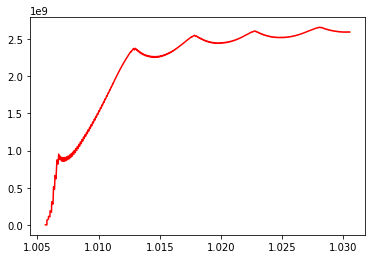

In [126]:
plt.plot(df_out_rec['time'], df_out_rec['data_amount']*8/(df_out_rec['time']-1.005595), color='red', label='average_th')

#### Load Data

In [5]:
# Reading data

#Data Amount
# Peixuan: Read throughput data from the file, these throughput data are the accumulated throughput
# Peixuan: 尝试打印看看有几位小数 
raw_data_0_HCS = pd.read_table('%s/HCS/throughput_0.txt'%(Directory), header=None)
raw_data_0_HCS.columns = ['Timestamp', 'Throughput']
raw_data_1_HCS = pd.read_table('%s/HCS/throughput_1.txt'%(Directory), header=None)
raw_data_1_HCS.columns = ['Timestamp', 'Throughput']
raw_data_2_HCS = pd.read_table('%s/HCS/throughput_2.txt'%(Directory), header=None)
raw_data_2_HCS.columns = ['Timestamp', 'Throughput']
raw_data_3_HCS = pd.read_table('%s/HCS/throughput_3.txt'%(Directory), header=None)
raw_data_3_HCS.columns = ['Timestamp', 'Throughput']

#start_time = 0.01
#Peixuan: Starting time becomes 0.01, remember to check this for each simulation, they might be differet


#Data Amount
raw_data_0_AFQ10 = pd.read_table('%s/AFQ10/throughput_0.txt'%(Directory), header=None)
raw_data_0_AFQ10.columns = ['Timestamp', 'Throughput']
raw_data_1_AFQ10 = pd.read_table('%s/AFQ10/throughput_1.txt'%(Directory), header=None)
raw_data_1_AFQ10.columns = ['Timestamp', 'Throughput']
raw_data_2_AFQ10 = pd.read_table('%s/AFQ10/throughput_2.txt'%(Directory), header=None)
raw_data_2_AFQ10.columns = ['Timestamp', 'Throughput']
raw_data_3_AFQ10 = pd.read_table('%s/AFQ10/throughput_3.txt'%(Directory), header=None)
raw_data_3_AFQ10.columns = ['Timestamp', 'Throughput']

#start_time = 0.01


#Data Amount
raw_data_0_AFQ100 = pd.read_table('%s/AFQ100/throughput_0.txt'%(Directory), header=None)
raw_data_0_AFQ100.columns = ['Timestamp', 'Throughput']
raw_data_1_AFQ100 = pd.read_table('%s/AFQ100/throughput_1.txt'%(Directory), header=None)
raw_data_1_AFQ100.columns = ['Timestamp', 'Throughput']
raw_data_2_AFQ100 = pd.read_table('%s/AFQ100/throughput_2.txt'%(Directory), header=None)
raw_data_2_AFQ100.columns = ['Timestamp', 'Throughput']
raw_data_3_AFQ100 = pd.read_table('%s/AFQ100/throughput_3.txt'%(Directory), header=None)
raw_data_3_AFQ100.columns = ['Timestamp', 'Throughput']

#start_time = 0.01


#Data Amount
raw_data_0_AFQ1000 = pd.read_table('%s/AFQ1000/throughput_0.txt'%(Directory), header=None)
raw_data_0_AFQ1000.columns = ['Timestamp', 'Throughput']
raw_data_1_AFQ1000 = pd.read_table('%s/AFQ1000/throughput_1.txt'%(Directory), header=None)
raw_data_1_AFQ1000.columns = ['Timestamp', 'Throughput']
raw_data_2_AFQ1000 = pd.read_table('%s/AFQ1000/throughput_2.txt'%(Directory), header=None)
raw_data_2_AFQ1000.columns = ['Timestamp', 'Throughput']
raw_data_3_AFQ1000 = pd.read_table('%s/AFQ1000/throughput_3.txt'%(Directory), header=None)
raw_data_3_AFQ1000.columns = ['Timestamp', 'Throughput']

#start_time = 0.01

#Data Amount
'''
raw_data_0_DropTail = pd.read_table('%s/DropTail/throughput_0.txt'%(Directory), header=None)
raw_data_0_DropTail.columns = ['Timestamp', 'Throughput']
raw_data_1_DropTail = pd.read_table('%s/DropTail/throughput_1.txt'%(Directory), header=None)
raw_data_1_DropTail.columns = ['Timestamp', 'Throughput']
raw_data_2_DropTail = pd.read_table('%s/DropTail/throughput_2.txt'%(Directory), header=None)
raw_data_2_DropTail.columns = ['Timestamp', 'Throughput']
raw_data_3_DropTail = pd.read_table('%s/DropTail/throughput_3.txt'%(Directory), header=None)
raw_data_3_DropTail.columns = ['Timestamp', 'Throughput']
'''

#start_time = 0.01

#Data Amount
raw_data_0_PQ = pd.read_table('%s/PQ/throughput_0.txt'%(Directory), header=None)
raw_data_0_PQ.columns = ['Timestamp', 'Throughput']
raw_data_1_PQ = pd.read_table('%s/PQ/throughput_1.txt'%(Directory), header=None)
raw_data_1_PQ.columns = ['Timestamp', 'Throughput']
raw_data_2_PQ = pd.read_table('%s/PQ/throughput_2.txt'%(Directory), header=None)
raw_data_2_PQ.columns = ['Timestamp', 'Throughput']
raw_data_3_PQ = pd.read_table('%s/PQ/throughput_3.txt'%(Directory), header=None)
raw_data_3_PQ.columns = ['Timestamp', 'Throughput']

#start_time = 0.01

/Users/kathy/Documents/Anaconda3/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  
/Users/kathy/Documents/Anaconda3/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  
/Users/kathy/Documents/Anaconda3/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  # Remove the CWD from sys.path while we load stuff.
/Users/kathy/Documents/Anaconda3/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  if sys.path[0] == '':
/Users/kathy/Documents/Anaconda3/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
/Users/kathy/Documents/Anaconda3/

#### Clean up data

In [6]:
# Translate into data amount

start_time = 0.01 # Peixuan: This is the starting time of the simulation, 
# Peixuan: try to make sure this with the first time stamp in the throughput_X.txt
#raw_data_0_HCS.head(1)

# Peixuan: here is use the average throughput multiple the time from the behginning of the simulation
# Peixuan: Average throughput * time = data transmitted
# Peixuan: So here is calculate the data transmitted so far

raw_data_0_HCS['Data'] = raw_data_0_HCS['Throughput']*(raw_data_0_HCS['Timestamp']-start_time)
raw_data_1_HCS['Data'] = raw_data_1_HCS['Throughput']*(raw_data_1_HCS['Timestamp']-start_time)
raw_data_2_HCS['Data'] = raw_data_2_HCS['Throughput']*(raw_data_2_HCS['Timestamp']-start_time)
raw_data_3_HCS['Data'] = raw_data_3_HCS['Throughput']*(raw_data_3_HCS['Timestamp']-start_time)

raw_data_0_AFQ10['Data'] = raw_data_0_AFQ10['Throughput']*(raw_data_0_AFQ10['Timestamp']-start_time)
raw_data_1_AFQ10['Data'] = raw_data_1_AFQ10['Throughput']*(raw_data_1_AFQ10['Timestamp']-start_time)
raw_data_2_AFQ10['Data'] = raw_data_2_AFQ10['Throughput']*(raw_data_2_AFQ10['Timestamp']-start_time)
raw_data_3_AFQ10['Data'] = raw_data_3_AFQ10['Throughput']*(raw_data_3_AFQ10['Timestamp']-start_time)

raw_data_0_AFQ100['Data'] = raw_data_0_AFQ100['Throughput']*(raw_data_0_AFQ100['Timestamp']-start_time)
raw_data_1_AFQ100['Data'] = raw_data_1_AFQ100['Throughput']*(raw_data_1_AFQ100['Timestamp']-start_time)
raw_data_2_AFQ100['Data'] = raw_data_2_AFQ100['Throughput']*(raw_data_2_AFQ100['Timestamp']-start_time)
raw_data_3_AFQ100['Data'] = raw_data_3_AFQ100['Throughput']*(raw_data_3_AFQ100['Timestamp']-start_time)

raw_data_0_AFQ1000['Data'] = raw_data_0_AFQ1000['Throughput']*(raw_data_0_AFQ1000['Timestamp']-start_time)
raw_data_1_AFQ1000['Data'] = raw_data_1_AFQ1000['Throughput']*(raw_data_1_AFQ1000['Timestamp']-start_time)
raw_data_2_AFQ1000['Data'] = raw_data_2_AFQ1000['Throughput']*(raw_data_2_AFQ1000['Timestamp']-start_time)
raw_data_3_AFQ1000['Data'] = raw_data_3_AFQ1000['Throughput']*(raw_data_3_AFQ1000['Timestamp']-start_time)

raw_data_0_PQ['Data'] = raw_data_0_PQ['Throughput']*(raw_data_0_PQ['Timestamp']-start_time)
raw_data_1_PQ['Data'] = raw_data_1_PQ['Throughput']*(raw_data_1_PQ['Timestamp']-start_time)
raw_data_2_PQ['Data'] = raw_data_2_PQ['Throughput']*(raw_data_2_PQ['Timestamp']-start_time)
raw_data_3_PQ['Data'] = raw_data_3_PQ['Throughput']*(raw_data_3_PQ['Timestamp']-start_time)

In [7]:
# Round up dec

dec = 4

raw_data_0_HCS = raw_data_0_HCS.round({'Timestamp':dec})
raw_data_1_HCS = raw_data_1_HCS.round({'Timestamp':dec})
raw_data_2_HCS = raw_data_2_HCS.round({'Timestamp':dec})
raw_data_3_HCS = raw_data_3_HCS.round({'Timestamp':dec})

raw_data_0_AFQ10 = raw_data_0_AFQ10.round({'Timestamp':dec})
raw_data_1_AFQ10 = raw_data_1_AFQ10.round({'Timestamp':dec})
raw_data_2_AFQ10 = raw_data_2_AFQ10.round({'Timestamp':dec})
raw_data_3_AFQ10 = raw_data_3_AFQ10.round({'Timestamp':dec})

raw_data_0_AFQ100 = raw_data_0_AFQ100.round({'Timestamp':dec})
raw_data_1_AFQ100 = raw_data_1_AFQ100.round({'Timestamp':dec})
raw_data_2_AFQ100 = raw_data_2_AFQ100.round({'Timestamp':dec})
raw_data_3_AFQ100 = raw_data_3_AFQ100.round({'Timestamp':dec})

raw_data_0_AFQ1000 = raw_data_0_AFQ1000.round({'Timestamp':dec})
raw_data_1_AFQ1000 = raw_data_1_AFQ1000.round({'Timestamp':dec})
raw_data_2_AFQ1000 = raw_data_2_AFQ1000.round({'Timestamp':dec})
raw_data_3_AFQ1000 = raw_data_3_AFQ1000.round({'Timestamp':dec})

raw_data_0_PQ = raw_data_0_PQ.round({'Timestamp':dec})
raw_data_1_PQ = raw_data_1_PQ.round({'Timestamp':dec})
raw_data_2_PQ = raw_data_2_PQ.round({'Timestamp':dec})
raw_data_3_PQ = raw_data_3_PQ.round({'Timestamp':dec})

In [8]:
# Peixuan: 确定时间轴(start, end, step)
timerange = np.linspace(0.01, 12.0, 120000)
# Peixuan: 保留小数
timerange = np.around(timerange, decimals=4)
# 10302019 to list
# Peixuan: 转化时间轴(timerange)格式成为list
timerange = timerange.tolist()

In [9]:
raw_data_0_HCS = process_data(raw_data_0_HCS, timerange)
raw_data_1_HCS = process_data(raw_data_1_HCS, timerange)
raw_data_2_HCS = process_data(raw_data_2_HCS, timerange)
raw_data_3_HCS = process_data(raw_data_3_HCS, timerange)

raw_data_0_AFQ10 = process_data(raw_data_0_AFQ10, timerange)
raw_data_1_AFQ10 = process_data(raw_data_1_AFQ10, timerange)
raw_data_2_AFQ10 = process_data(raw_data_2_AFQ10, timerange)
raw_data_3_AFQ10 = process_data(raw_data_3_AFQ10, timerange)

raw_data_0_AFQ100 = process_data(raw_data_0_AFQ100, timerange)
raw_data_1_AFQ100 = process_data(raw_data_1_AFQ100, timerange)
raw_data_2_AFQ100 = process_data(raw_data_2_AFQ100, timerange)
raw_data_3_AFQ100 = process_data(raw_data_3_AFQ100, timerange)

raw_data_0_AFQ1000 = process_data(raw_data_0_AFQ1000, timerange)
raw_data_1_AFQ1000 = process_data(raw_data_1_AFQ1000, timerange)
raw_data_2_AFQ1000 = process_data(raw_data_2_AFQ1000, timerange)
raw_data_3_AFQ1000 = process_data(raw_data_3_AFQ1000, timerange)

raw_data_0_PQ = process_data(raw_data_0_PQ, timerange)
raw_data_1_PQ = process_data(raw_data_1_PQ, timerange)
raw_data_2_PQ = process_data(raw_data_2_PQ, timerange)
raw_data_3_PQ = process_data(raw_data_3_PQ, timerange)

In [10]:
raw_data_0_AFQ10

,Throughput,Data,Timestamp
Timestamp,,,
0.0100,0.00,0.000000,0.0100
0.0101,0.00,0.000000,0.0101
0.0102,0.00,0.000000,0.0102
0.0103,0.00,0.000000,0.0103
0.0104,0.00,0.000000,0.0104
0.0105,0.00,0.000000,0.0105
0.0106,0.00,0.000000,0.0106
0.0107,0.00,0.000000,0.0107
0.0108,0.00,0.000000,0.0108


### Plotting

#### Gearbox

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
/Users/kathy/Documents/Anaconda3/anaconda/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


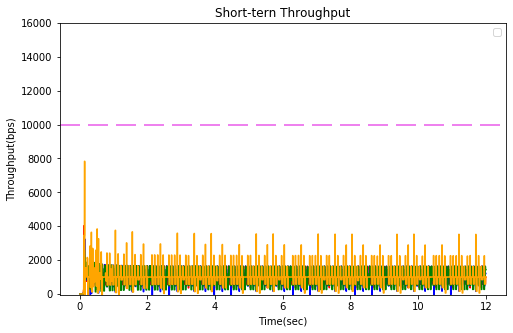

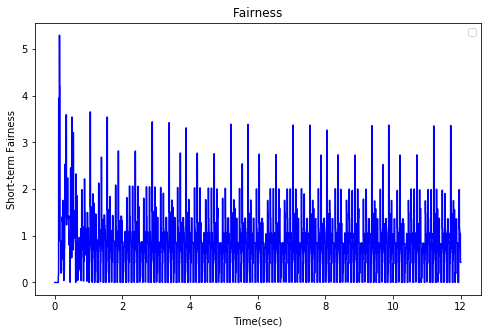

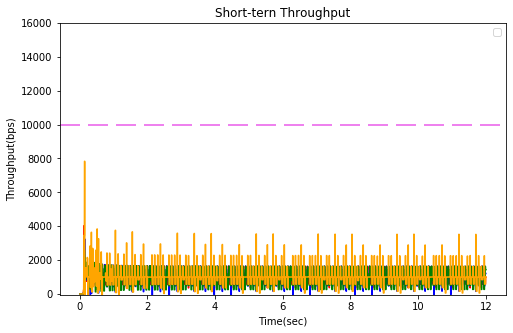

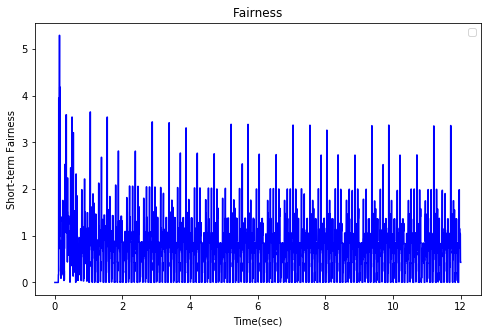

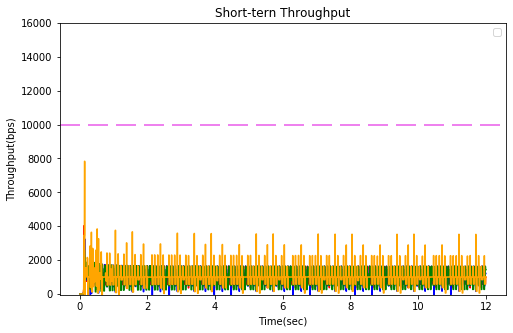

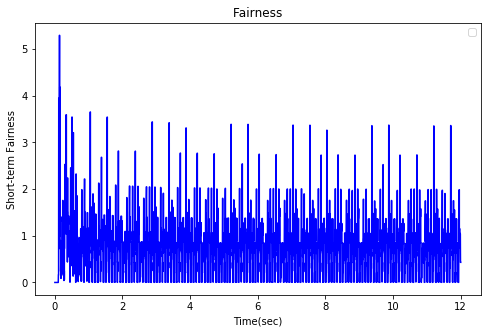

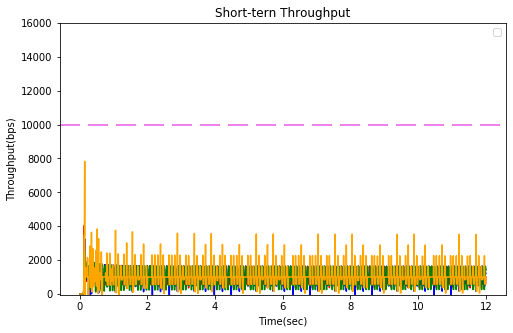

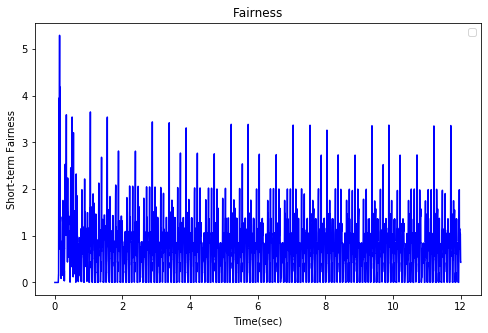

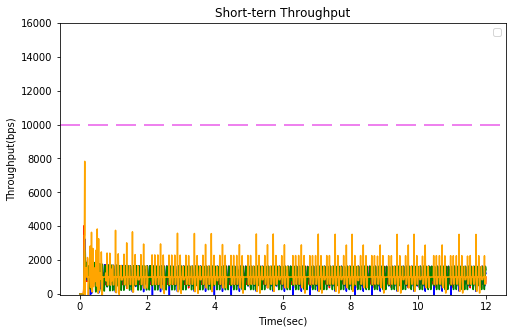

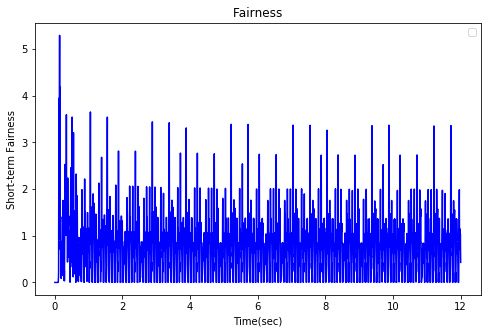

In [11]:
# Loop
period_list = [0.0001, 0.0005, 0.001, 0.005, 0.01]
step_list = [1, 5, 10, 50, 100]
average_fairness_HCS = []

index_list = [0, 1, 2, 3, 4]
#for i in np.linspace(0, len(period_list), 1):
#for i in np.linspace(0, 5, 1):
for i in index_list:
    measure_fairness(raw_data_0_HCS, raw_data_1_HCS, raw_data_2_HCS, raw_data_3_HCS, period_list[i], step_list[i], average_fairness_HCS)

#### AFQ10

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


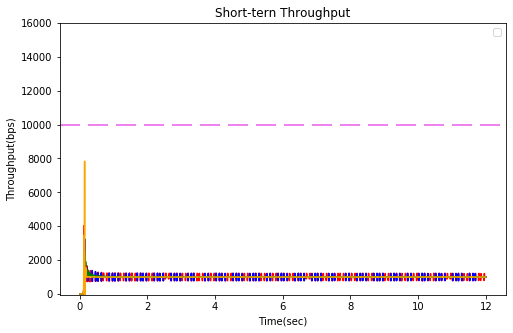

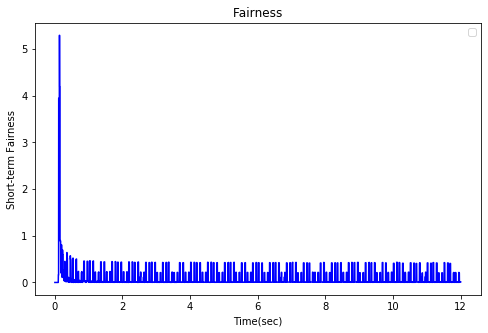

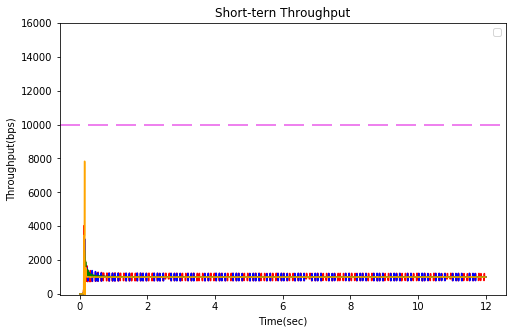

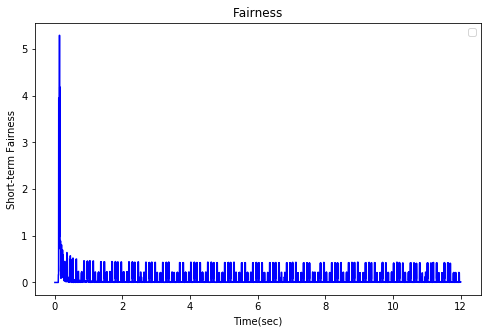

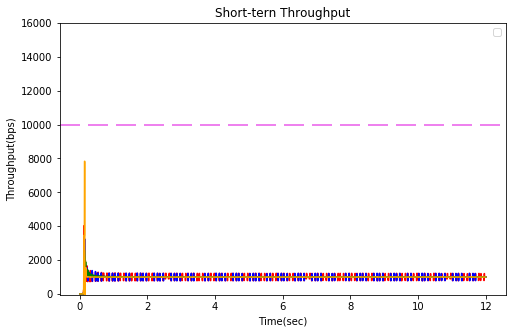

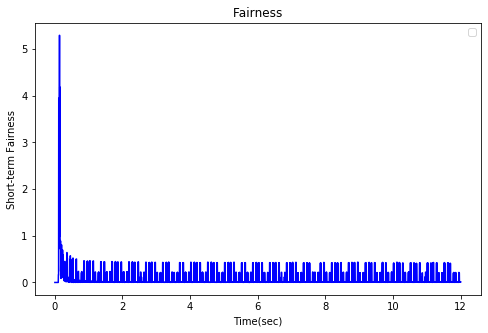

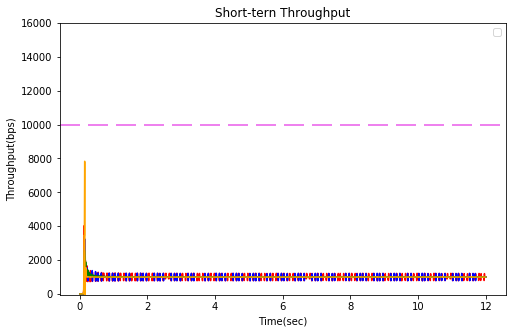

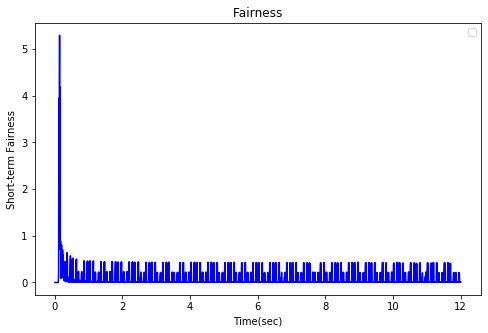

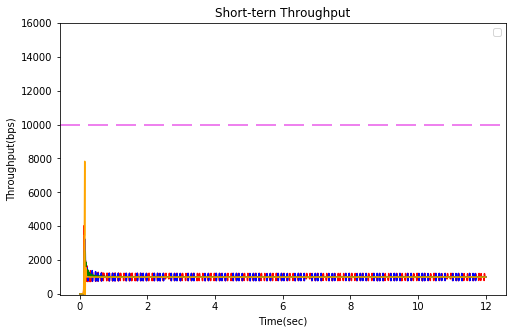

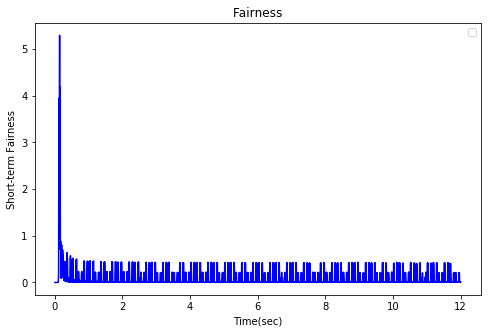

In [12]:
# Loop
period_list = [0.0001, 0.0005, 0.001, 0.005, 0.01]
step_list = [1, 5, 10, 50, 100]
average_fairness_AFQ10 = []

index_list = [0, 1, 2, 3, 4]
#for i in np.linspace(0, len(period_list), 1):
#for i in np.linspace(0, 5, 1):
for i in index_list:
    measure_fairness(raw_data_0_AFQ10, raw_data_1_AFQ10, raw_data_2_AFQ10, raw_data_3_AFQ10, period_list[i], step_list[i], average_fairness_AFQ10)

#### AFQ100

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


[2.4836067578275376, 2.4727176803842896, 2.4611868766631964, 2.3705512298786906, 2.2574281090305806]


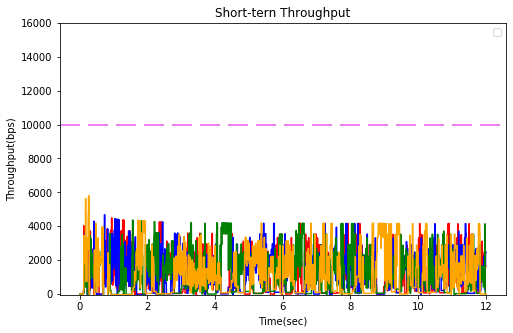

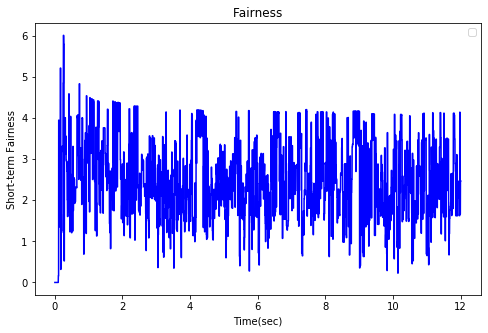

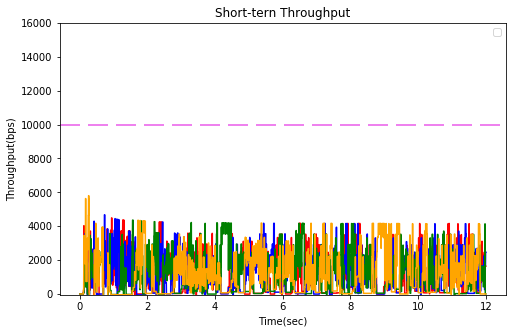

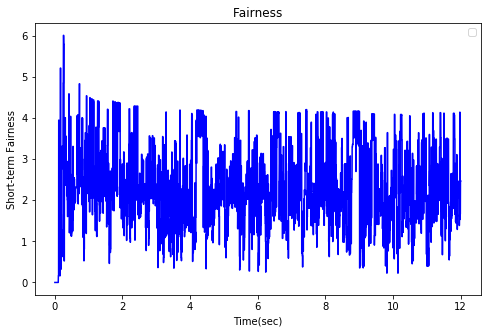

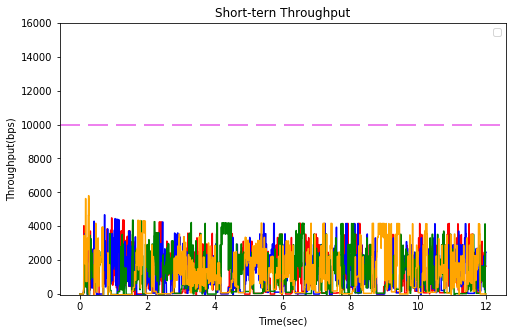

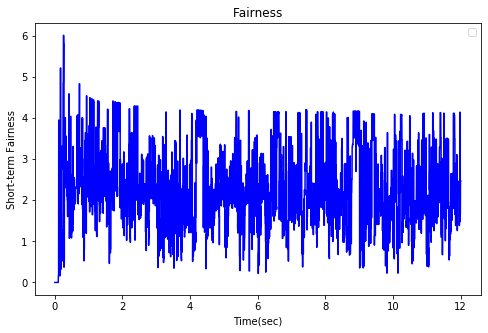

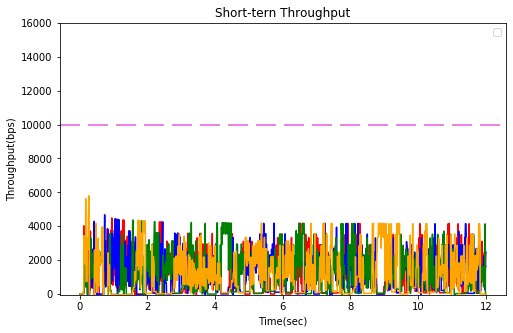

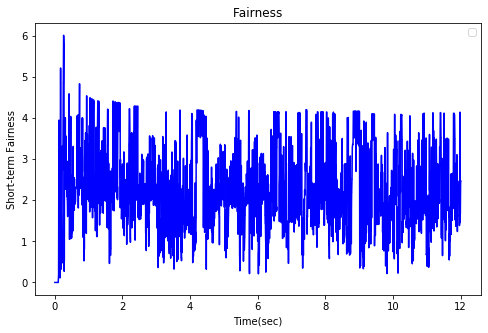

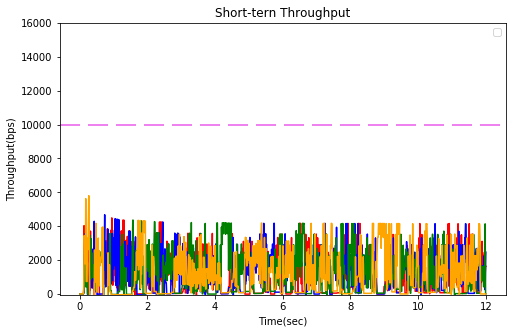

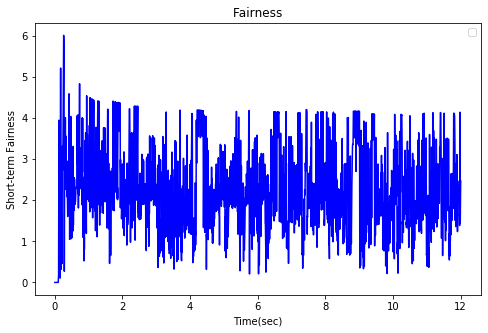

In [13]:
# Loop
period_list = [0.0001, 0.0005, 0.001, 0.005, 0.01]
step_list = [1, 5, 10, 50, 100]
average_fairness_AFQ100 = []

index_list = [0, 1, 2, 3, 4]
#for i in np.linspace(0, len(period_list), 1):
#for i in np.linspace(0, 5, 1):
for i in index_list:
    measure_fairness(raw_data_0_AFQ100, raw_data_1_AFQ100, raw_data_2_AFQ100, raw_data_3_AFQ100, period_list[i], step_list[i], average_fairness_AFQ100)
print (average_fairness_AFQ100)

#### AFQ1000

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


[2.531576905050438, 2.5200821172696215, 2.5079151747967678, 2.4121643127710795, 2.29267013537565]


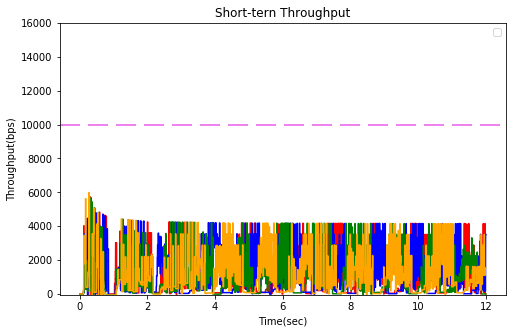

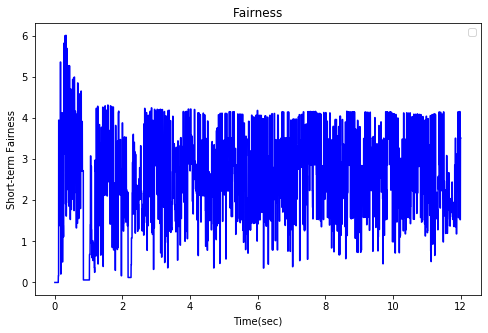

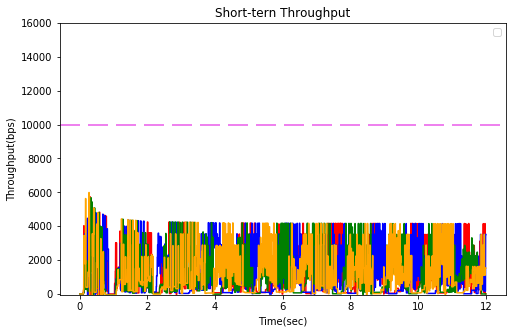

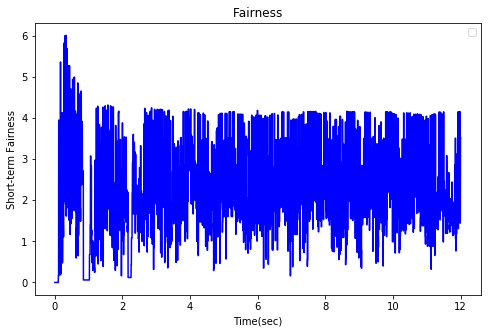

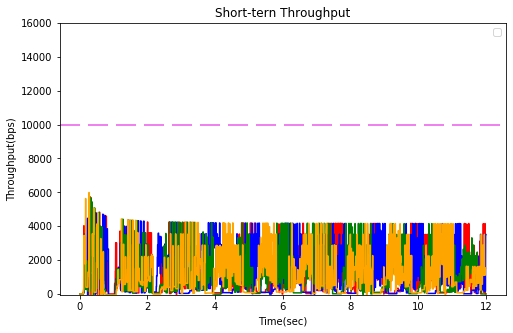

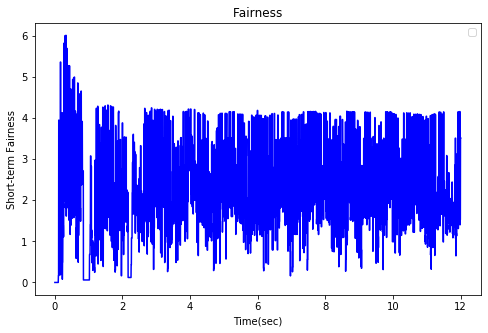

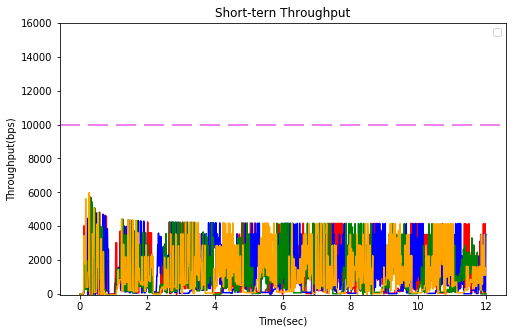

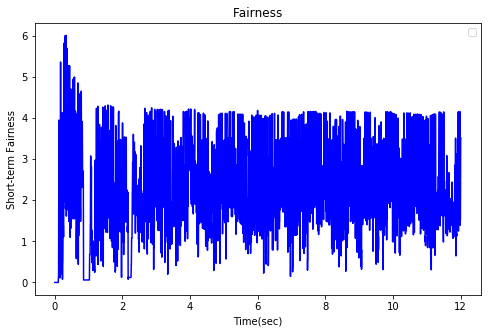

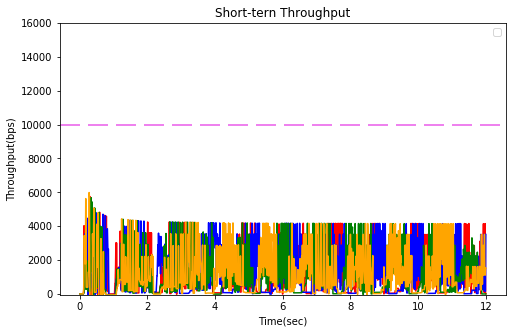

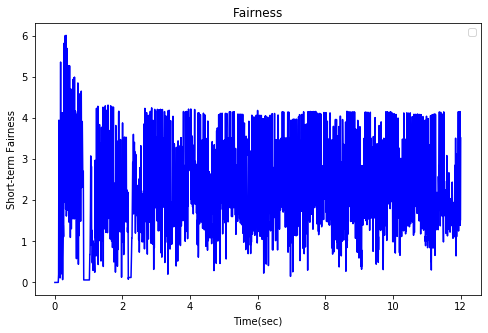

In [14]:
# Loop
period_list = [0.0001, 0.0005, 0.001, 0.005, 0.01]
step_list = [1, 5, 10, 50, 100]
average_fairness_AFQ1000 = []

index_list = [0, 1, 2, 3, 4]
#for i in np.linspace(0, len(period_list), 1):
#for i in np.linspace(0, 5, 1):
for i in index_list:
    measure_fairness(raw_data_0_AFQ1000, raw_data_1_AFQ1000, raw_data_2_AFQ1000, raw_data_3_AFQ1000, period_list[i], step_list[i], average_fairness_AFQ1000)
print (average_fairness_AFQ1000)

In [15]:
#### PQ

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


[0.40085537965712148, 0.3996382961336658, 0.39834811520929281, 0.38820499998290348, 0.37554785589782064]


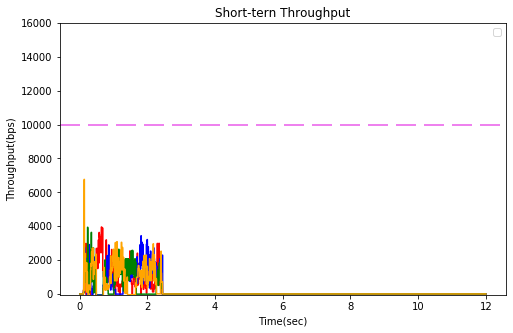

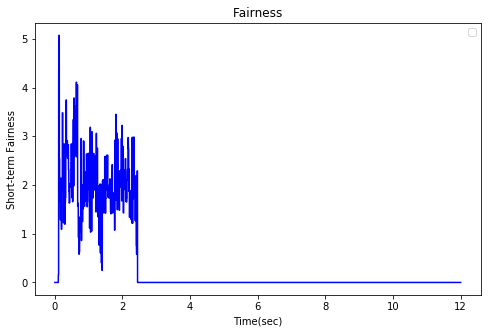

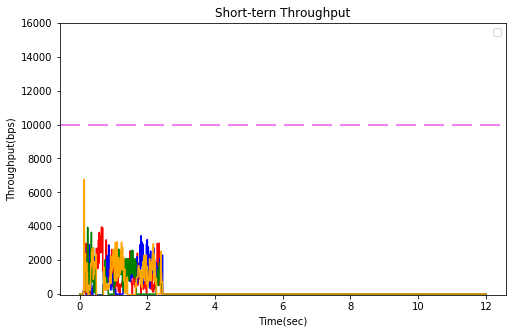

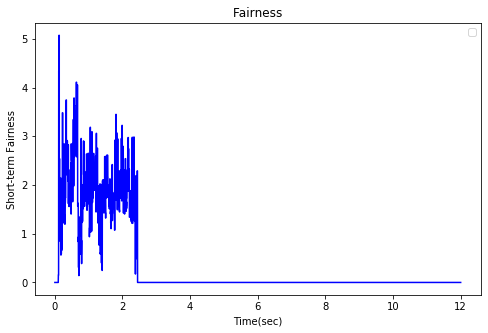

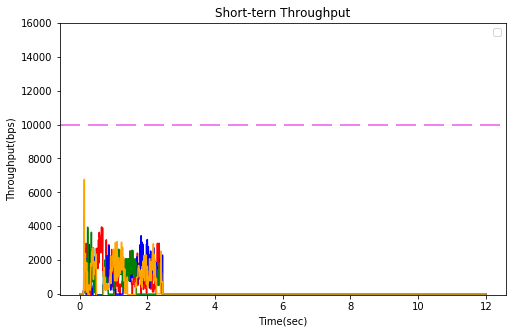

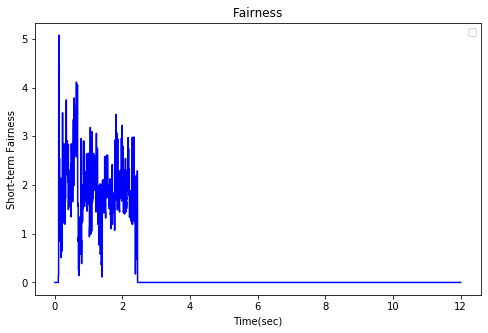

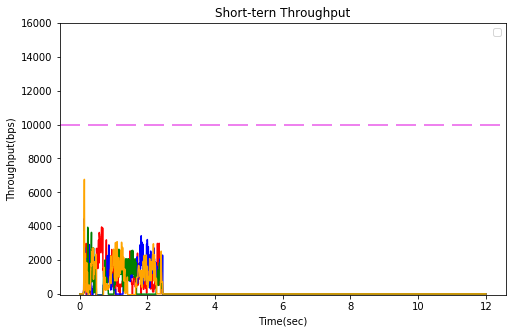

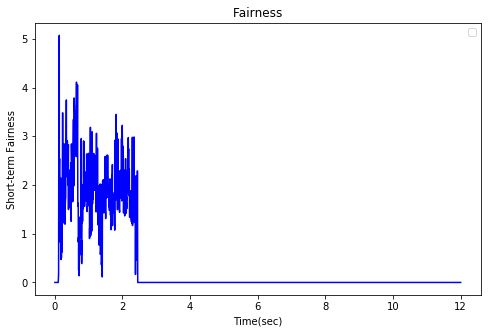

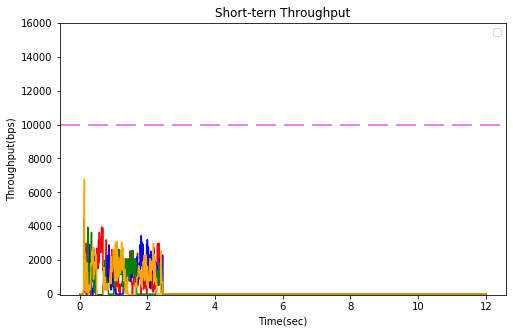

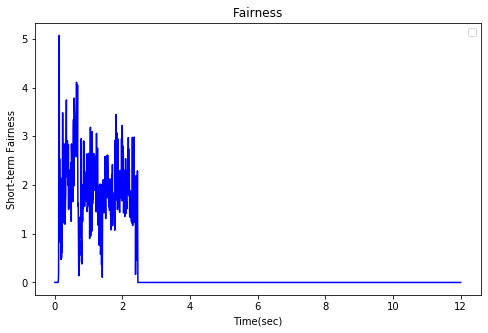

In [16]:
# Loop
period_list = [0.0001, 0.0005, 0.001, 0.005, 0.01]
step_list = [1, 5, 10, 50, 100]
average_fairness_PQ = []

index_list = [0, 1, 2, 3, 4]
#for i in np.linspace(0, len(period_list), 1):
#for i in np.linspace(0, 5, 1):
for i in index_list:
    measure_fairness(raw_data_0_PQ, raw_data_1_PQ, raw_data_2_PQ, raw_data_3_PQ, period_list[i], step_list[i], average_fairness_PQ)
print (average_fairness_PQ)

### Plotting Fairness

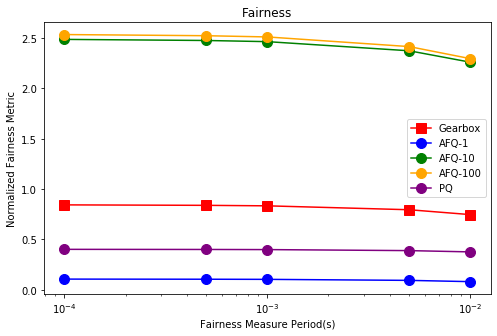

In [17]:
plt.figure(figsize=(8,5))
#plt.plot(x,y,"b--",linewidth=1)   #在当前绘图对象绘图（X轴，Y轴，蓝色虚线，线宽度）
plt.xlabel("Fairness Measure Period(s)")
plt.ylabel("Normalized Fairness Metric")
plt.xscale('log')
plt.title("Fairness")

period_list = [0.0001, 0.0005, 0.001, 0.005, 0.01]
line1 = plt.plot(period_list, average_fairness_HCS, color='red', marker='s', markersize = 10, label='Gearbox')
line2 = plt.plot(period_list, average_fairness_AFQ10, color='blue', marker='o', markersize = 10, label='AFQ-1')
line3 = plt.plot(period_list, average_fairness_AFQ100, color='green', marker='o', markersize = 10, label='AFQ-10')
line4 = plt.plot(period_list, average_fairness_AFQ1000, color='orange', marker='o', markersize = 10, label='AFQ-100')
line5 = plt.plot(period_list, average_fairness_PQ, color='purple', marker='o', markersize = 10, label='PQ')

#plt.legend([line1, line2, line3, line4], loc='best')
plt.legend(loc='best')
plt.show()